In [1]:
import ares
import numpy as np
import matplotlib.pyplot as pl
import distpy

In [2]:
# Independent variables
redshifts = np.array([3, 3.8, 4, 4.9, 5, 5.9, 6, 6.9, 7, 7.9, 8])
MUV = np.arange(-28, -8.8, 0.2)
Mh = np.logspace(7, 13, 61)

# blob 1: the LF. Give it a name, and the function needed to calculate it.
blob_n1 = ['galaxy_lf']
blob_i1 = [('z', redshifts), ('x', MUV)]
blob_f1 = ['LuminosityFunction']

# blob 2: the SFE. Same deal.
blob_n2 = ['fstar']
blob_i2 = [('z', redshifts), ('Mh', Mh)]
blob_f2 = ['fstar']

In [3]:
blob_pars = \
{
 'blob_names': [blob_n1, blob_n2],
 'blob_ivars': [blob_i1, blob_i2],
 'blob_funcs': [blob_f1, blob_f2],
 'blob_kwargs': [None] * 2,
}

In [4]:
#define the parameters that remain unchanged
base_pars = ares.util.ParameterBundle('mirocha2017:base').pars_by_pop(0, True)
base_pars.update(blob_pars)

# This is important!
base_pars['pop_calib_lum'] = None

In [5]:
free_pars = \
  [
   'pq_func_par0[0]',
   'pq_func_par1[0]',
   'pq_func_par2[0]',
   'pq_func_par3[0]',
  ]
#which pars belong to what?

is_log = [True, True, False, False]

from distpy.distribution import UniformDistribution
from distpy.distribution import DistributionSet

ps = DistributionSet()
ps.add_distribution(UniformDistribution(-3, 0.), 'pq_func_par0[0]')
ps.add_distribution(UniformDistribution(9, 13),  'pq_func_par1[0]')
ps.add_distribution(UniformDistribution(0, 2),   'pq_func_par2[0]')
ps.add_distribution(UniformDistribution(-2, 0),  'pq_func_par3[0]')

In [7]:
guesses = \
{
 'pq_func_par0[0]': -1,
 'pq_func_par1[0]': 11.5,
 'pq_func_par2[0]': 0.5,
 'pq_func_par3[0]': -0.5,
}

In [8]:
# Initialize a fitter object and give it the data to be fit
fitter_lf = ares.inference.FitGalaxyPopulation(**base_pars)

# The data can also be provided more explicitly
#I seem to need this or else the run throws error: Must set data by hand! 
# fitter_lf.redshifts = {‘lf’: [5.9]}
fitter_lf.data = 'bouwens2015'

# fitter_lf.data('bouwens2015')

In [9]:
fitter = ares.inference.ModelFit(**base_pars)
fitter.add_fitter(fitter_lf)

# Establish the object to which we'll pass parameters
from ares.populations.GalaxyCohort import GalaxyCohort
fitter.simulator = GalaxyCohort

In [10]:
fitter.save_hmf = True  # cache HMF for a speed-up!
fitter.save_psm = True  # cache source SED model (e.g., BPASS, S99)

# Setting this flag to False will make ARES generate new files for each checkpoint.
# 2-D blobs can get large, so this allows us to just download a single
# snapshot or two if we'd like (useful if running on remote machine)
fitter.checkpoint_append = False

fitter.parameters = free_pars
fitter.is_log = is_log
fitter.prior_set = ps

# In general, the more the merrier (~hundreds)
fitter.nwalkers = 50

fitter.jitter = [0.1] * len(fitter.parameters)
fitter.guesses = guesses

# Run the thing
fitter.run('test_lfcal', burn=3, steps=15, save_freq=1, clobber=True)

Saved HaloMassFunction instance to limit I/O.
# Starting burn-in: Wed Jun 17 10:45:54 2020
# Wrote test_lfcal.burn.dd0000.facc.pkl: Wed Jun 17 10:49:01 2020
# Wrote test_lfcal.burn.dd0001.facc.pkl: Wed Jun 17 10:50:29 2020
# Wrote test_lfcal.burn.dd0002.facc.pkl: Wed Jun 17 10:52:02 2020
# Burn-in complete in 368 seconds.
# Starting MCMC: Wed Jun 17 10:52:02 2020
# Wrote test_lfcal.dd0000.facc.pkl: Wed Jun 17 10:55:08 2020
# Wrote test_lfcal.dd0001.facc.pkl: Wed Jun 17 10:56:31 2020
# Wrote test_lfcal.dd0002.facc.pkl: Wed Jun 17 10:57:59 2020
# Wrote test_lfcal.dd0003.facc.pkl: Wed Jun 17 10:59:26 2020
# Wrote test_lfcal.dd0004.facc.pkl: Wed Jun 17 11:00:50 2020
# Wrote test_lfcal.dd0005.facc.pkl: Wed Jun 17 11:02:13 2020
# Wrote test_lfcal.dd0006.facc.pkl: Wed Jun 17 11:03:36 2020
# Wrote test_lfcal.dd0007.facc.pkl: Wed Jun 17 11:04:58 2020
# Wrote test_lfcal.dd0008.facc.pkl: Wed Jun 17 11:06:20 2020
# Wrote test_lfcal.dd0009.facc.pkl: Wed Jun 17 11:07:42 2020
# Wrote test_lfcal.dd001

In [11]:
anl = ares.analysis.ModelSet('test_lfcal')


##############################################################################################################
####                                         Analysis: Model Set                                          ####
##############################################################################################################
#### ---------------------------------------------------------------------------------------------------- ####
#### Basic Information                                                                                    ####
#### ---------------------------------------------------------------------------------------------------- ####
#### path        : ./                                                                                     ####
#### prefix      : test_lfcal                                                                             ####
#### N-d         : 4                                                                                      ####


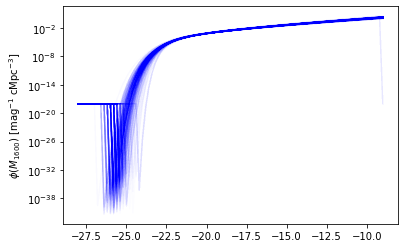

In [17]:
#look at the raw LF samples
ax = anl.ReconstructedFunction('galaxy_lf', ivar=[6, None], samples='all', color='b', alpha=0.01)

ax.set_yscale('log')

# WARNING: finkelstein2015 wavelength=1500.0A, not 1600A!


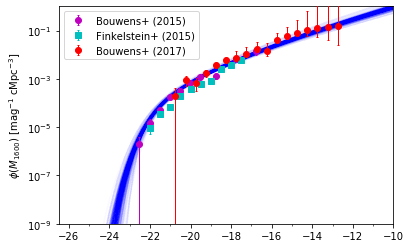

In [31]:
gpop = ares.analysis.GalaxyPopulation()

ax = anl.ReconstructedFunction('galaxy_lf', ivar=[6, None], samples='all', color='b', alpha=0.01)

# Plot any data within dz=0.1 of z=6
gpop.PlotLF(6, ax=ax, round_z=0.1)

ax.set_ylim(1e-9, 1)
ax.legend()
pl.show()

My first try at fitting

In [12]:
# Independent variables
redshifts = np.array([3, 3.8, 4, 4.9, 5, 5.9, 6, 6.9, 7, 7.9, 8])
MUV = np.arange(-28, -8.8, 0.2)
# Mh = np.logspace(7, 13, 61)

# blob 1: the LF. Give it a name, and the function needed to calculate it.
blob_n1 = ['galaxy_lf']
blob_i1 = [('z', redshifts), ('x', MUV)]
blob_f1 = ['LuminosityFunction']

# # blob 2: the SFE. Same deal.
# blob_n2 = ['fstar']
# blob_i2 = [('z', redshifts), ('Mh', Mh)]
# blob_f2 = ['fstar']

In [13]:
blob_pars = \
{
 'blob_names': [blob_n1],
 'blob_ivars': [blob_i1],
 'blob_funcs': [blob_f1],
 'blob_kwargs': [None],
}

In [14]:
#define the parameters that remain unchanged
base_pars = ares.util.ParameterBundle('emma:model1')
base_pars.update(blob_pars)
# base_pars.update({'progress_bar': True, 'debug':True}) #this doesn't seem to do anything

# This is important!
base_pars['pop_calib_lum'] = None

In [22]:
free_pars = \
  [
   'pq_func_par0[4]', #this is the constant
#    'pq_func_par1[4]', #offset
#    'pq_func_par2[4]', #slope
  ]

is_log = [False]#, False, False]

from distpy.distribution import UniformDistribution
from distpy.distribution import DistributionSet

ps = DistributionSet()
ps.add_distribution(UniformDistribution(1e-8, 4e-1), 'pq_func_par0[4]')
# ps.add_distribution(UniformDistribution(0, 1e-1),  'pq_func_par1[4]')
# ps.add_distribution(UniformDistribution(0, 1e-1),   'pq_func_par2[4]')

In [23]:
guesses = \
{
 'pq_func_par0[4]': 3e-4,
#  'pq_func_par1[4]': 0,
#  'pq_func_par2[4]': 0,
}

In [24]:
# Initialize a fitter object and give it the data to be fit
fitter_lf = ares.inference.FitGalaxyPopulation(**base_pars)

# The data can also be provided more explicitly
#I seem to need this or else the run throws error: Must set data by hand! 
# fitter_lf.redshifts = {‘lf’: [5.9]}
fitter_lf.data = 'bouwens2015'

# print(fitter_lf.data)

In [25]:
fitter = ares.inference.ModelFit(**base_pars)
fitter.add_fitter(fitter_lf)

# Establish the object to which we'll pass parameters
from ares.populations.GalaxyHOD import GalaxyHOD
fitter.simulator = GalaxyHOD

In [19]:
fitter.save_hmf = True  # cache HMF for a speed-up!
fitter.save_psm = True  # cache source SED model (e.g., BPASS, S99)

# Setting this flag to False will make ARES generate new files for each checkpoint.
# 2-D blobs can get large, so this allows us to just download a single
# snapshot or two if we'd like (useful if running on remote machine)
fitter.checkpoint_append = False

fitter.parameters = free_pars
# fitter.is_log = is_log
fitter.prior_set = ps

# In general, the more the merrier (~hundreds)
fitter.nwalkers = 26

fitter.jitter = [0.001] * len(fitter.parameters)
fitter.guesses = guesses
# fitter.pops

# Fixing position of walker 6 (parameter pq_func_par0[4])
# Moved from -0.001420624050075001 to 0.0006569578176328551
# Fixing position of walker 9 (parameter pq_func_par0[4])
# Moved from -0.0001257848196478603 to 0.0006569578176328551
# Fixing position of walker 11 (parameter pq_func_par0[4])
# Moved from -0.0006160813502805661 to 0.0005148102146836119
# Fixing position of walker 19 (parameter pq_func_par0[4])
# Moved from -0.00044049839502686674 to 2.866104059646166e-05
# Fixing position of walker 20 (parameter pq_func_par0[4])
# Moved from -0.0012395592582057466 to 0.0006577048714481489


In [20]:
# Run the thing
fitter.run('test_lfcal', burn=4, steps=20, save_freq=1, clobber=True)

Saved HaloMassFunction instance to limit I/O.
# Starting burn-in: Fri Jun 19 15:35:23 2020
# Wrote test_lfcal.burn.dd0000.facc.pkl: Fri Jun 19 15:35:36 2020
# Wrote test_lfcal.burn.dd0001.facc.pkl: Fri Jun 19 15:35:41 2020
# Wrote test_lfcal.burn.dd0002.facc.pkl: Fri Jun 19 15:35:48 2020
# Wrote test_lfcal.burn.dd0003.facc.pkl: Fri Jun 19 15:35:54 2020
# Burn-in complete in 30.5 seconds.
# Fixing position of walker 3 (parameter pq_func_par0[4])
# Moved from -0.0006676672425205395 to 0.0008476673185763555
# Fixing position of walker 8 (parameter pq_func_par0[4])
# Moved from -0.00021014576306413116 to 0.00046431259799047656
# Fixing position of walker 9 (parameter pq_func_par0[4])
# Moved from -0.0003551618422834289 to 0.0006870584821602794
# Fixing position of walker 11 (parameter pq_func_par0[4])
# Moved from -9.963168057917048e-05 to 0.0010443777633590413
# Fixing position of walker 14 (parameter pq_func_par0[4])
# Moved from -0.00015860765359939358 to 0.0003815474051724098
# Fixing 

In [26]:
anl = ares.analysis.ModelSet('test_lfcal')



##############################################################################################################
####                                         Analysis: Model Set                                          ####
##############################################################################################################
#### ---------------------------------------------------------------------------------------------------- ####
#### Basic Information                                                                                    ####
#### ---------------------------------------------------------------------------------------------------- ####
#### path        : ./                                                                                     ####
#### prefix      : test_lfcal                                                                             ####
#### N-d         : 1                                                                                      ####


# WARNING: finkelstein2015 wavelength=1500.0A, not 1600A!


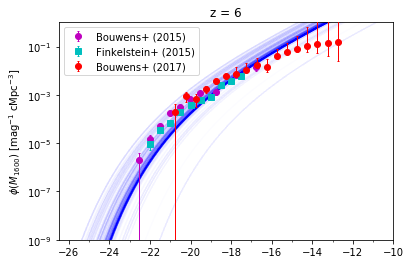

In [39]:
gpop = ares.analysis.GalaxyPopulation()

ax = anl.ReconstructedFunction('galaxy_lf', ivar=[6, None], samples='all', color='b', alpha=0.01)

# Plot any data within dz=0.1 of z=6
gpop.PlotLF(6, ax=ax, round_z=0.2)
ax.set_title("z = 6")

ax.set_ylim(1e-9, 1)
ax.legend()
pl.show()

In [42]:
z = 6
# free_pars

anl.TrianglePlot(pars='pq_func_par0[4]', ivar=[z])#, label_panels=free_pars)

# (pars=params, ivar=[z, None, None, None, None, None, None, None], \
#                  label_panels=params

KeyError: 'Blob pq_func_par0[4] not found.'

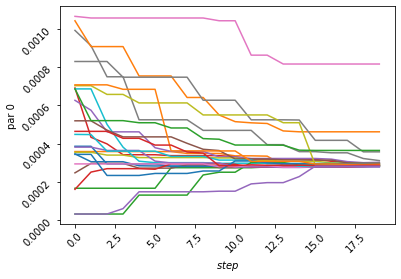

In [29]:
anl.WalkerTrajectories('pq_func_par0[4]', N=25)